# Setup: Imports & Data Generation

In [1]:
# --- Setup: Imports & Data Generation ---
from objective_functions import compute_objective
from prox_operators   import prox_l1, prox_elastic_net
import numpy            as np
import pandas           as pd
import matplotlib.pyplot as plt
import time, tracemalloc, importlib

# import modules under distinct names so reload() works
import iterative_solvers

# bring solver functions & stats‑getters into scope
from iterative_solvers import (
    estimate_lipschitz,
    ista,
    fista,
    fista_delta,
    get_metrics     # returns grad & line‑search stats
)

# hook L‑BFGS into the SAME grad timer
import lbfgs
lbfgs.grad_call_times = iterative_solvers.grad_call_times

from lbfgs import LBFGSSolver

# data generator
from easy_boston_data import generate_correlated_boston_like_data

# global tolerance
TOL = 1e-10

def clear_timers():
    # ISTA/FISTA line‑search & gradient
    iterative_solvers.grad_call_times.clear()
    iterative_solvers.ls_call_times.clear()
    iterative_solvers.ls_call_iters.clear()

In [2]:
""" # --- DATASET PARAMETER SWEEP (ADD THIS CELL) ---
# we will vary seed, noise level, and correlations to get non‐zero metric variance
seeds      = [0, 1, 2, 3, 4]
noise_stds = [0.5, 1.0, 2.0, 5.0]
rho1_vals  = [0.5, 0.8]   # correlation in block1
rho2_vals  = [0.7, 0.9]   # correlation in block2
REPS       = 5           # number of repeats per configuration """


# --- DATASET PARAMETER SWEEP (ADD THIS CELL) ---
# we will vary seed, noise level, and correlations to get non‐zero metric variance
seeds      = [0, 1]
noise_stds = [0.5, 1.0]
rho1_vals  = [0.5, 0.8]   # correlation in block1
rho2_vals  = [0.7, 0.9]   # correlation in block2
REPS       = 5           # number of repeats per configuration

# Alpha selection

In [3]:
def select_effective_alphas(reg_type, alpha1, alpha2, eps=1e-8):
    """
    Determine the actual ℓ₁ (alpha1) and ℓ₂ (alpha2) weights to use,
    treating any component < eps as zero.

    - Pure Lasso   : keep ℓ₁, zero ℓ₂
    - Pure Ridge   : zero ℓ₁, keep ℓ₂
    - Elastic-Net  :
        • if ℓ₁ negligible and ℓ₂ significant  → Ridge
        • if ℓ₂ negligible and ℓ₁ significant  → Lasso
        • if both significant                  → Elastic-Net
        • if both negligible                   → No regularization
    """
    if reg_type == "lasso":
        return alpha1, 0.0

    elif reg_type == "ridge":
        return 0.0, alpha2

    elif reg_type == "elasticnet":
        l1_small = abs(alpha1) < eps
        l2_small = abs(alpha2) < eps

        if l1_small and not l2_small:
            # ℓ₁ term is negligible ⇒ pure Ridge
            return 0.0, alpha2

        elif l2_small and not l1_small:
            # ℓ₂ term is negligible ⇒ pure Lasso
            return alpha1, 0.0

        elif l1_small and l2_small:
            # both negligible ⇒ no regularization
            return 0.0, 0.0

        else:
            # both non-negligible ⇒ true Elastic-Net
            return alpha1, alpha2

    else:
        raise ValueError(f"Unsupported reg_type={reg_type!r}")


# Preprocessing & Regularization Settings

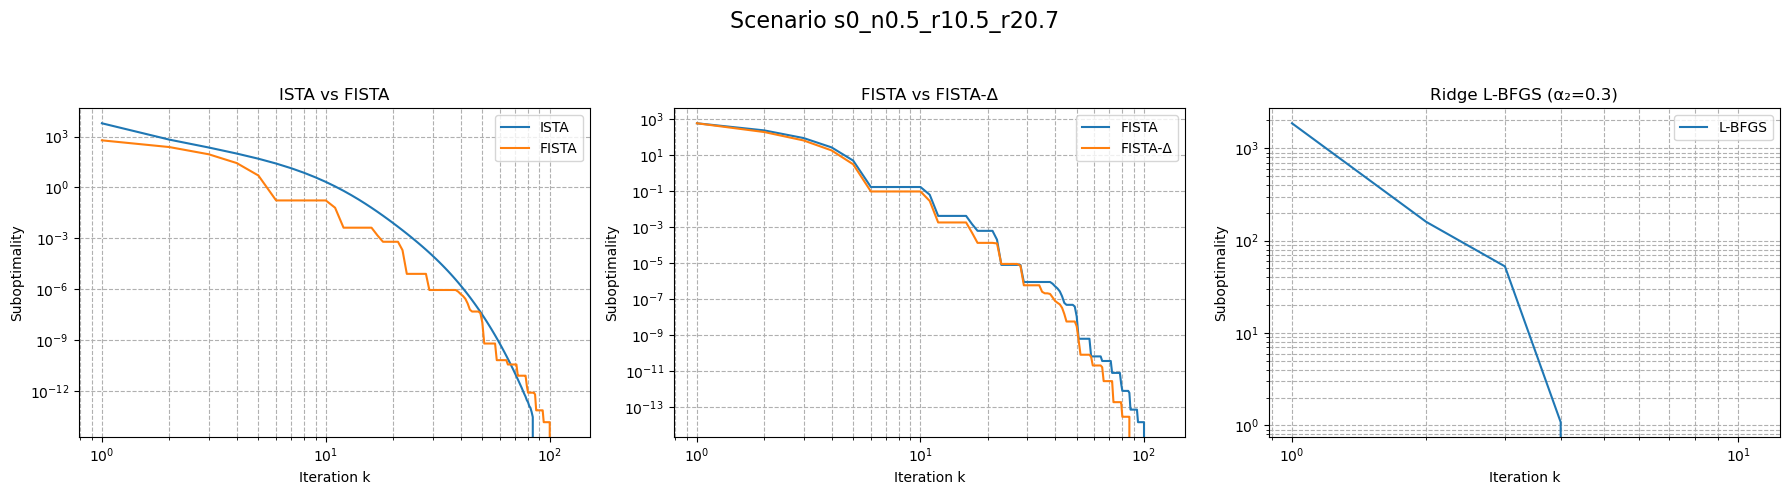

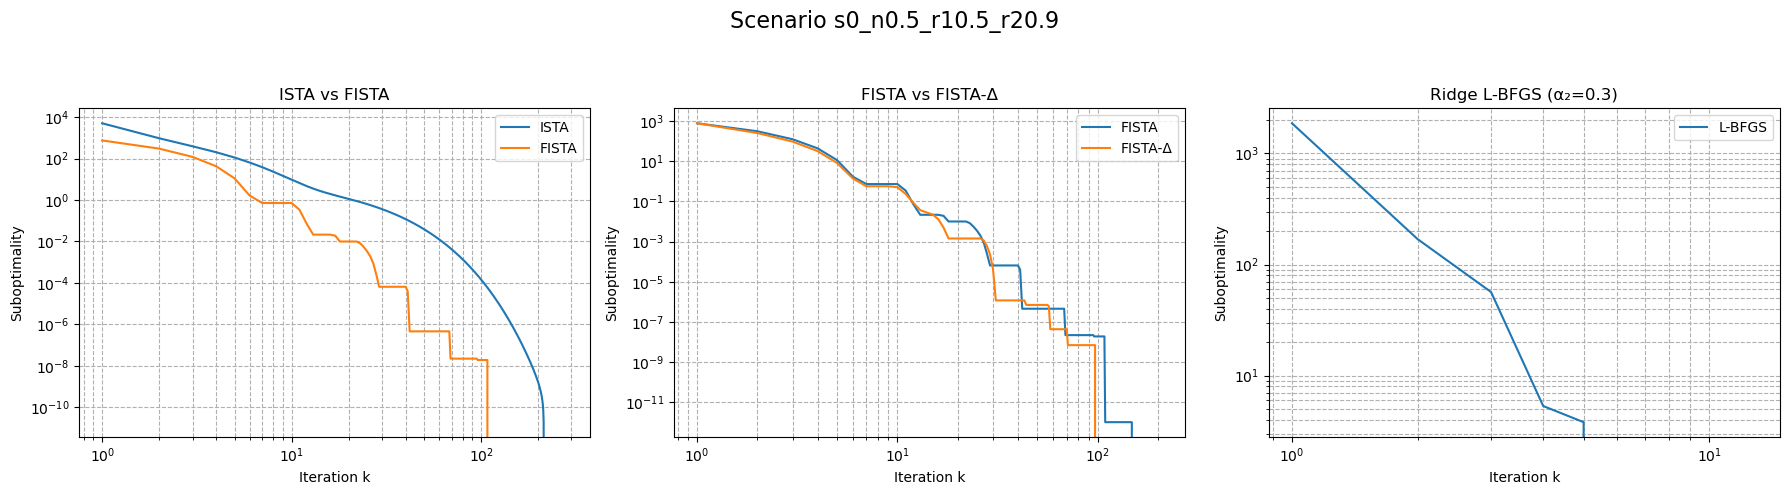

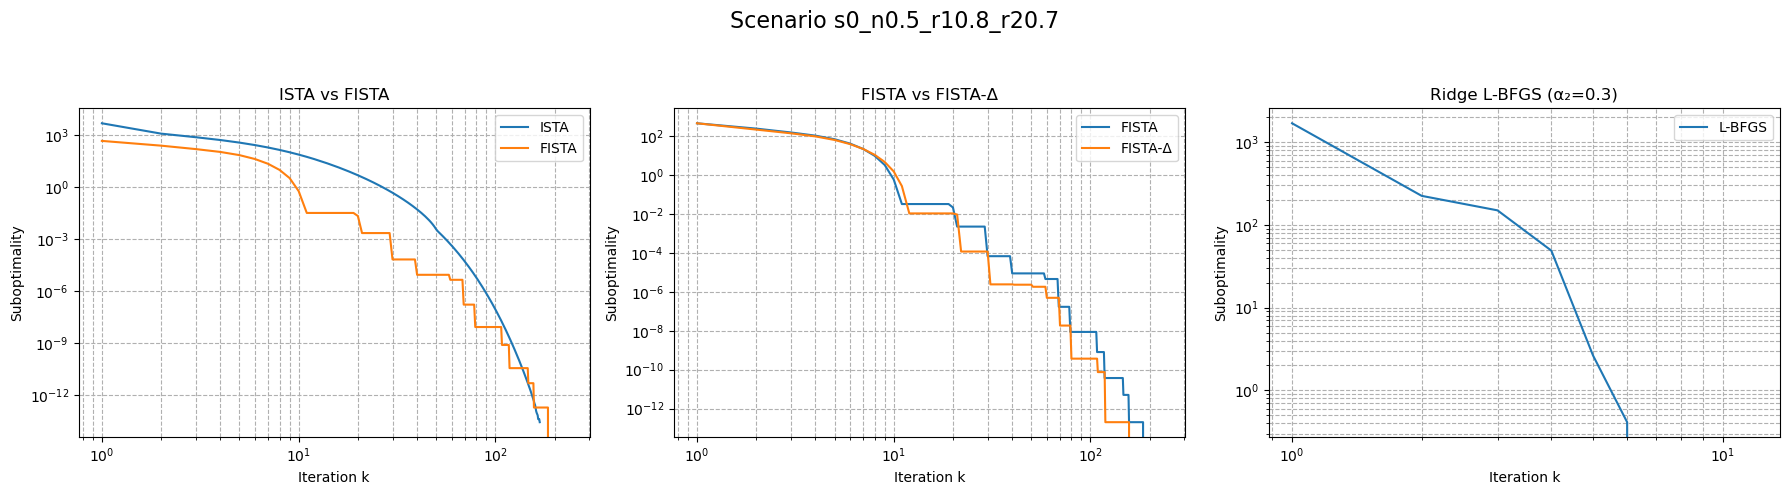

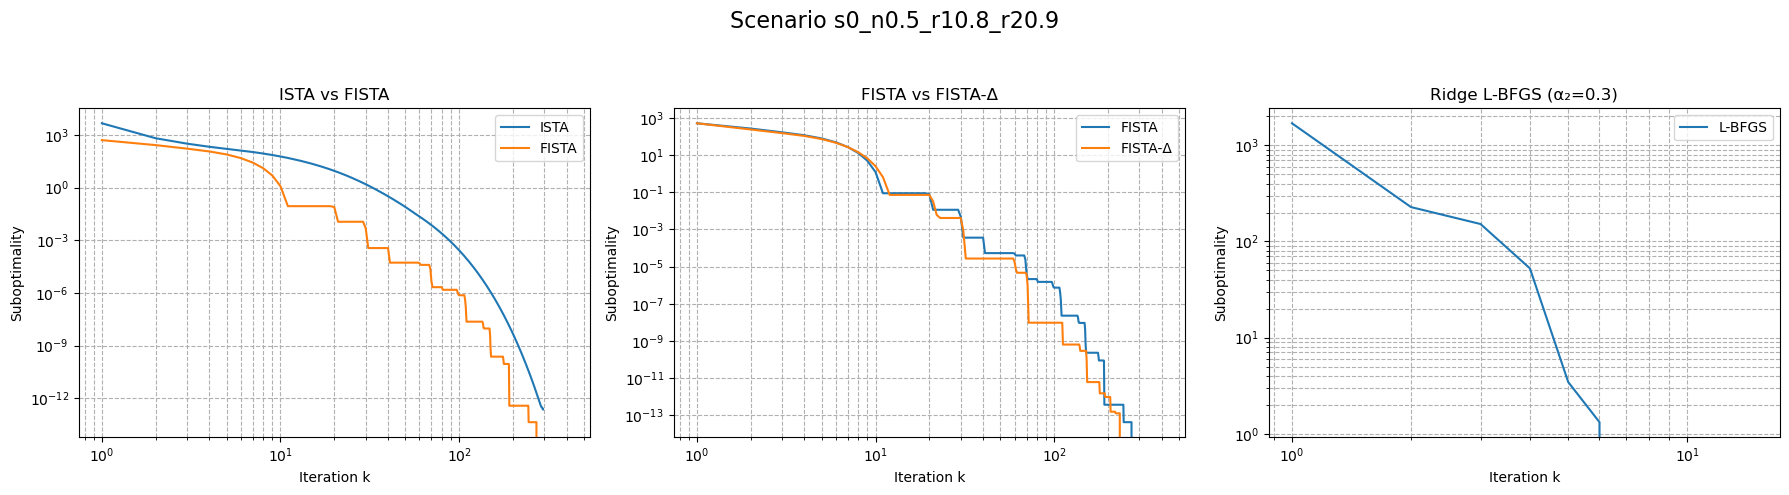

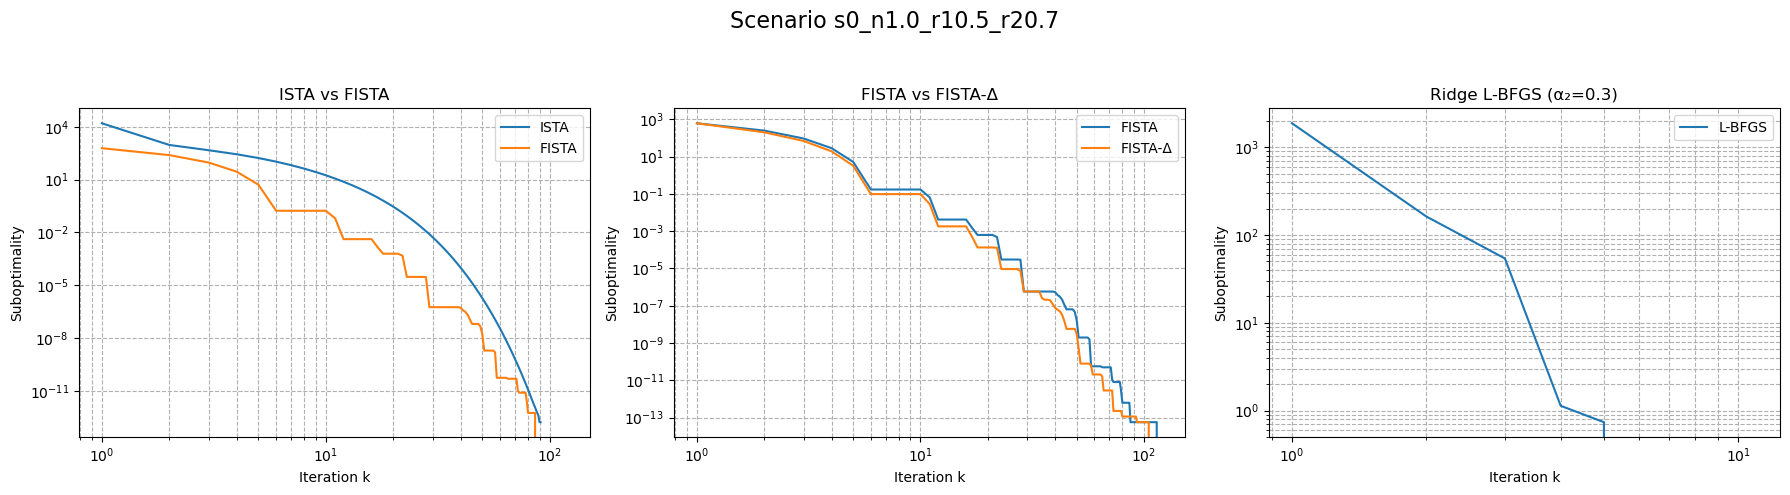

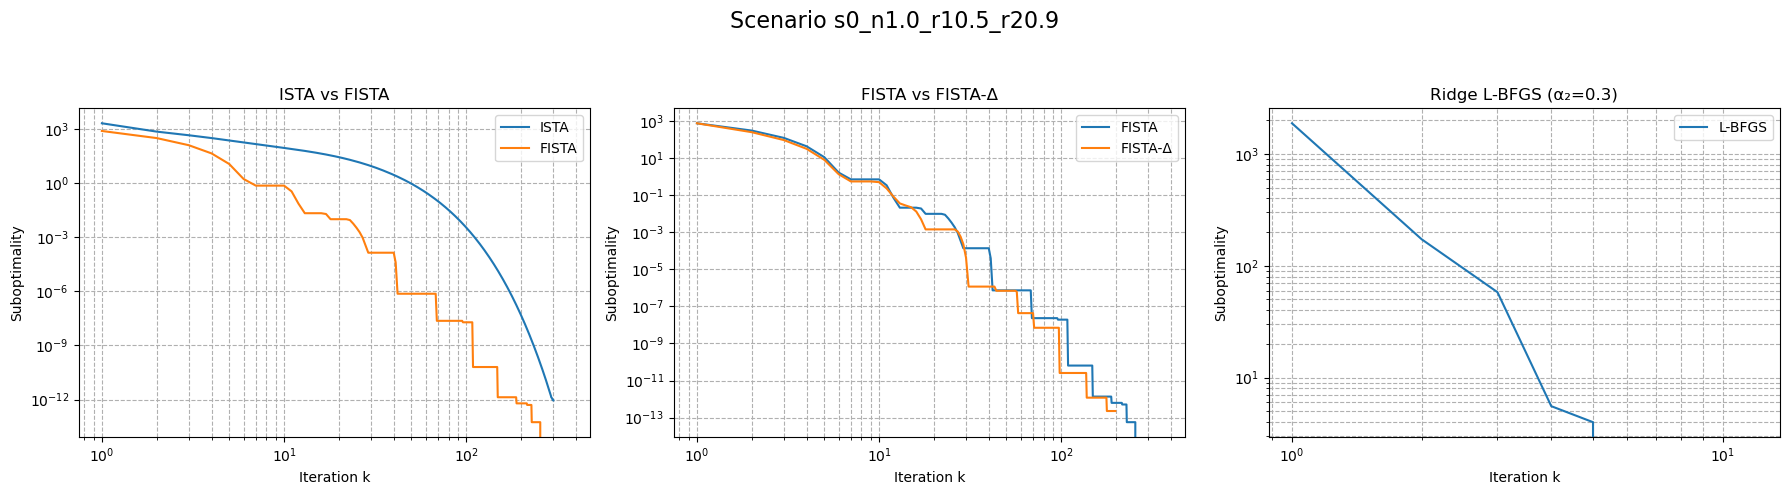

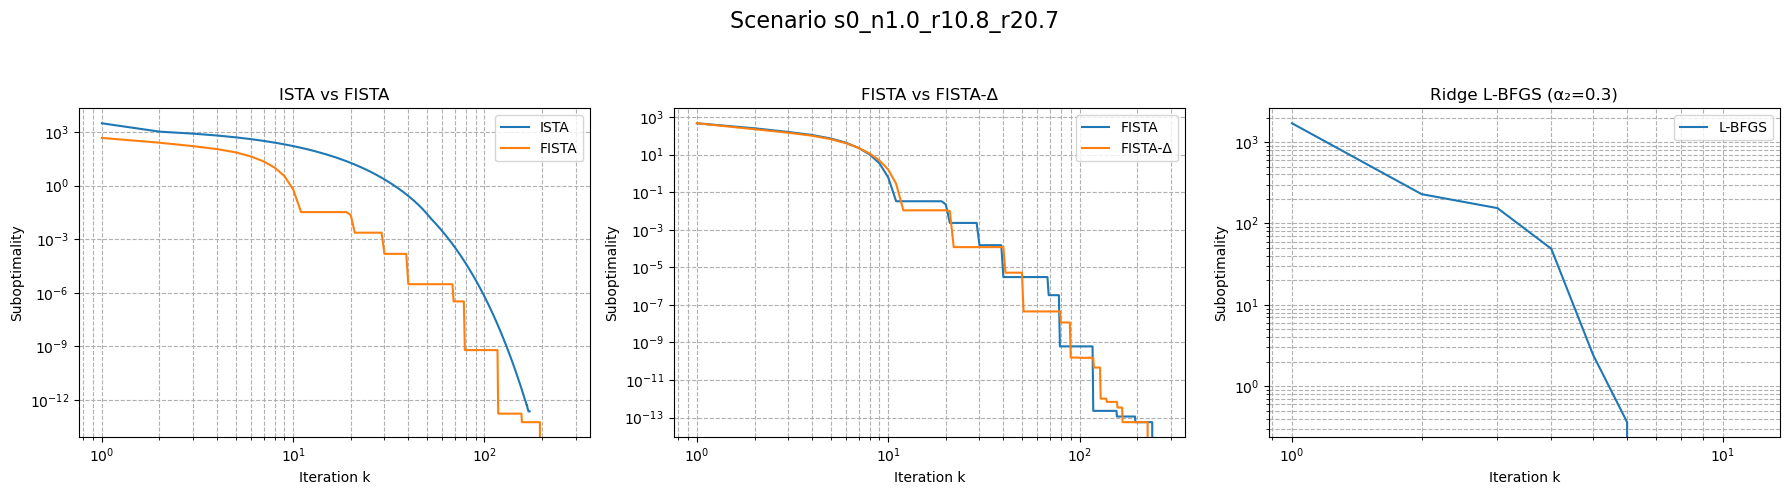

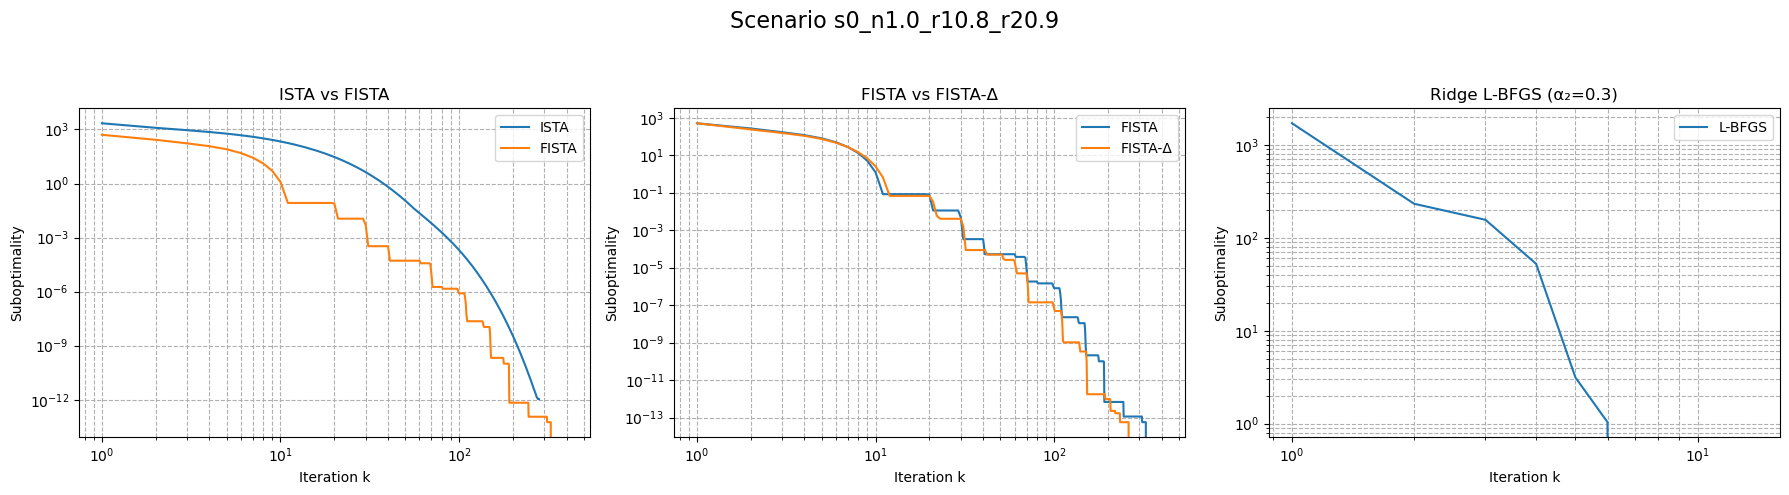

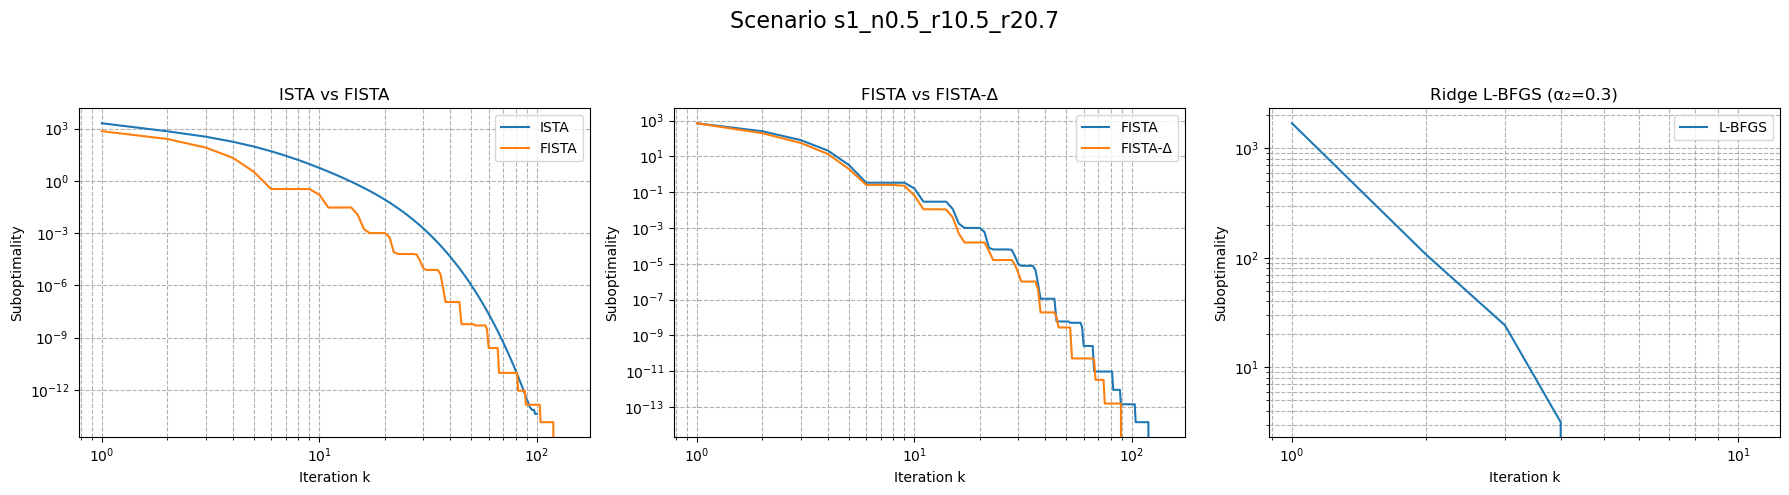

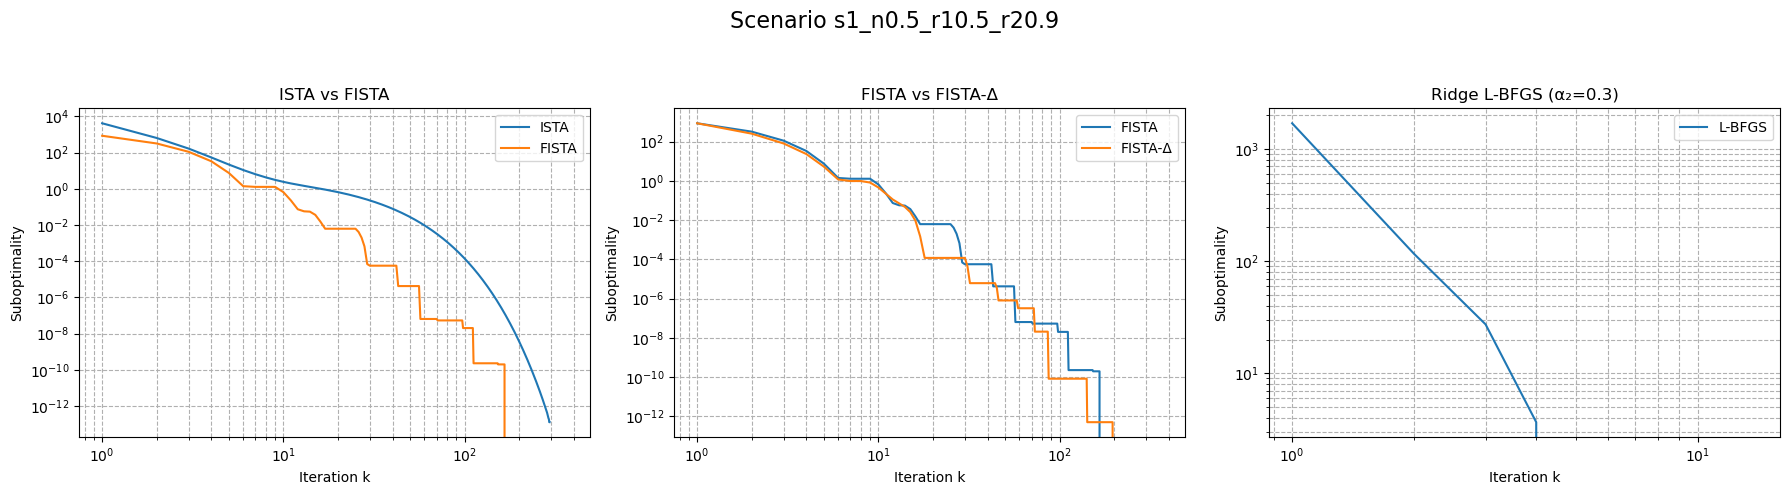

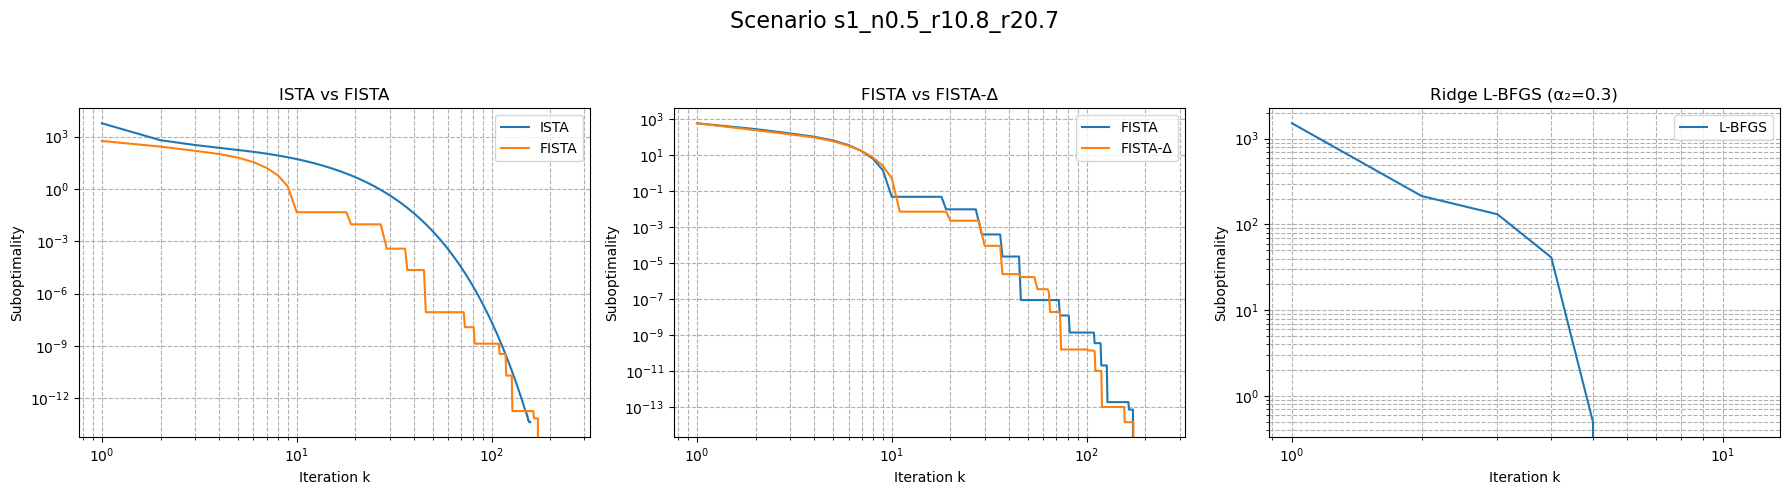

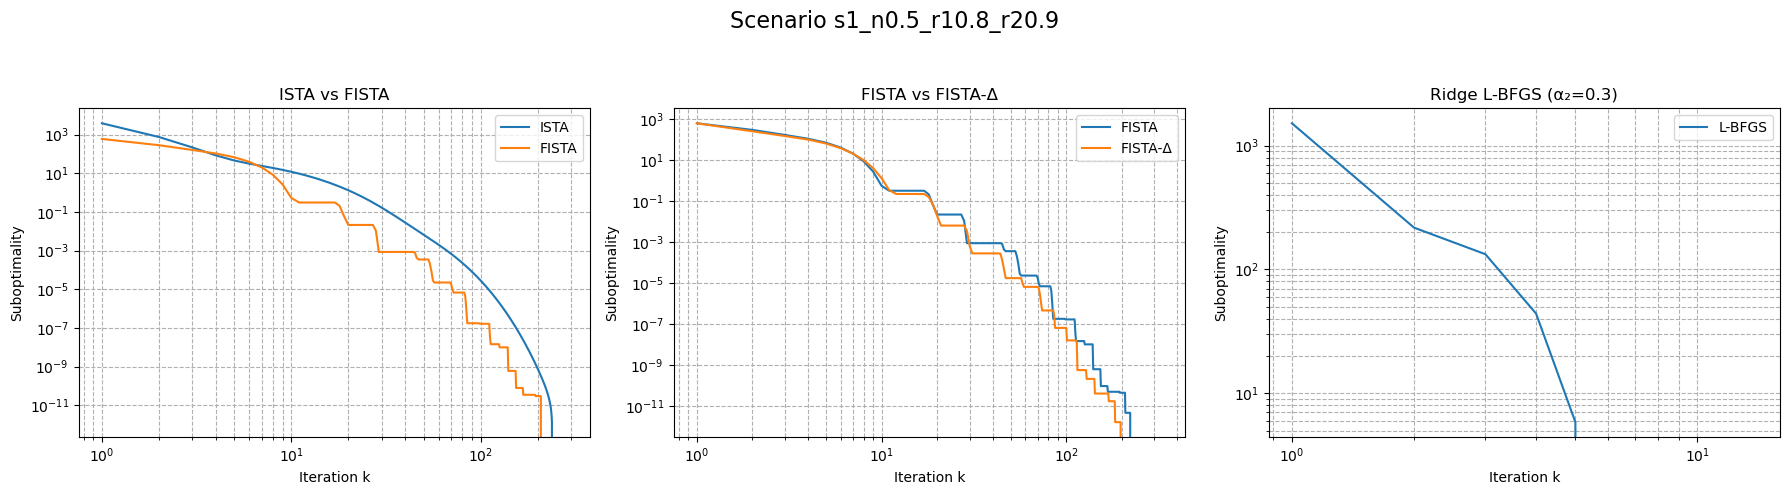

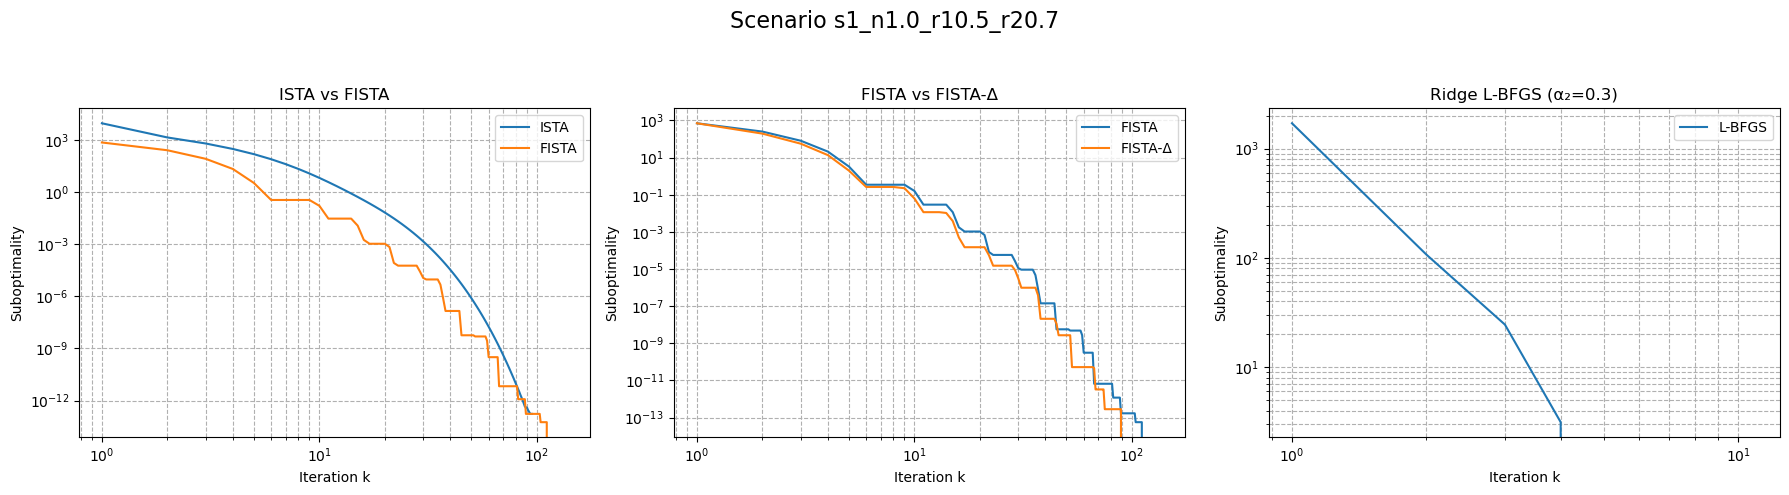

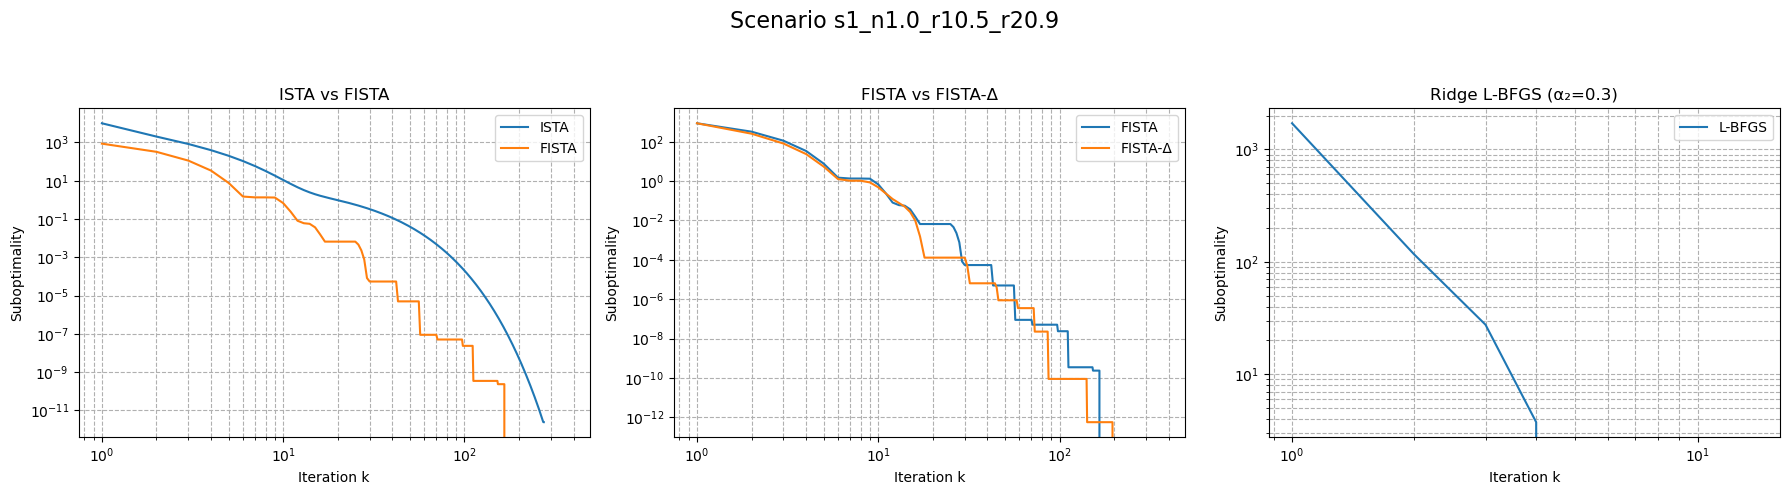

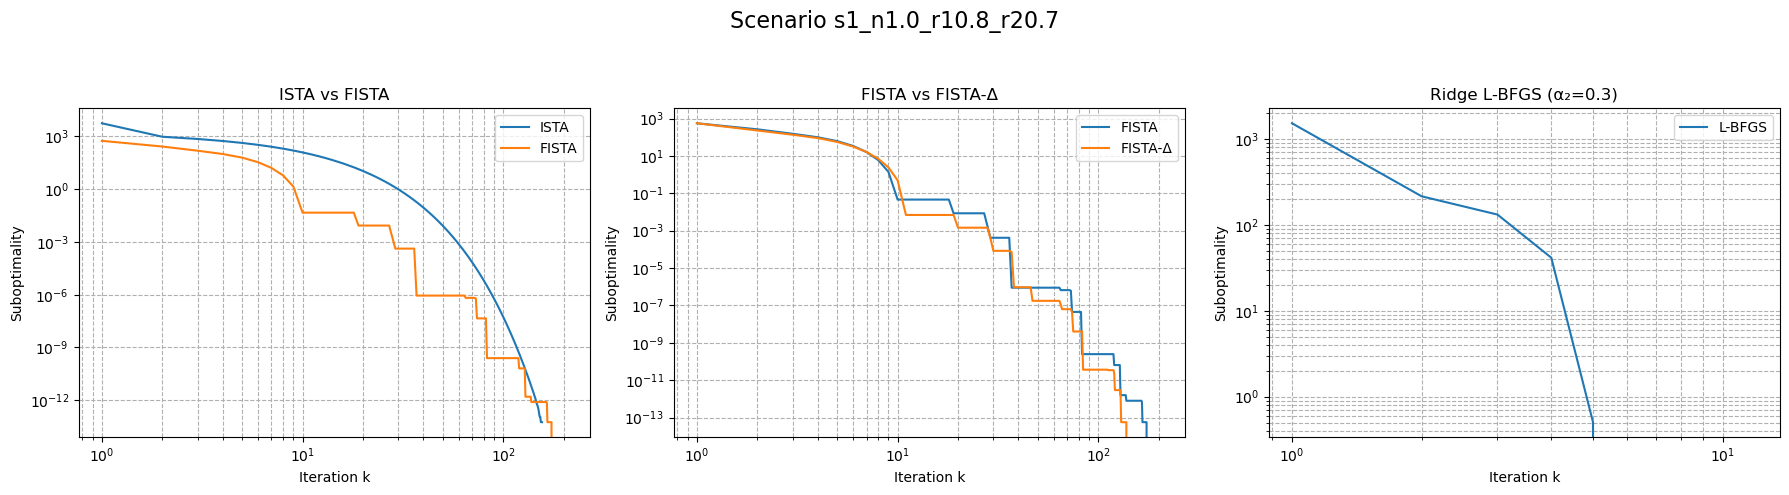

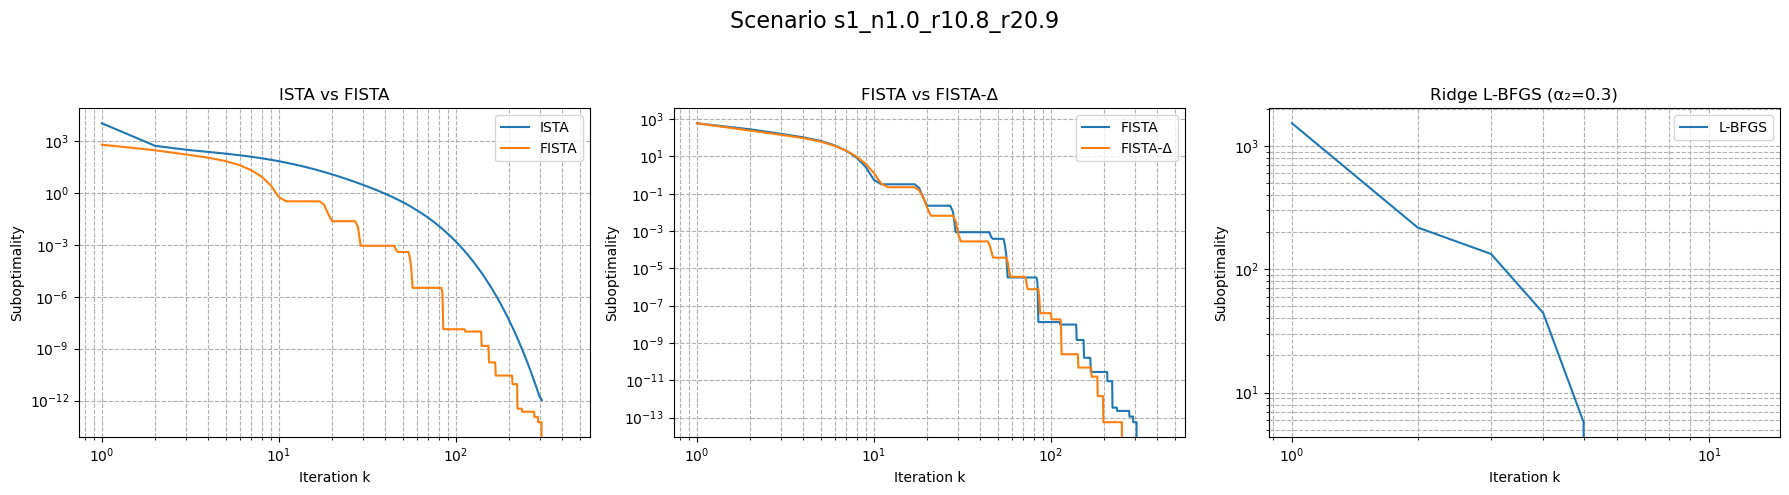

In [4]:
# — PREPROCESSING & REGULARIZATION SETTINGS (MODIFIED) —
import pandas as pd

basic_regs = [
    {'name':'lasso',      'alpha1':0.3,   'alpha2':0.0},
    {'name':'lasso',      'alpha1':0.6,   'alpha2':0.0},
    {'name':'lasso',      'alpha1':1.0,   'alpha2':0.0},
    {'name':'ridge',      'alpha1':0.0,   'alpha2':0.3},
    {'name':'ridge',      'alpha1':0.0,   'alpha2':0.6},
    {'name':'ridge',      'alpha1':0.0,   'alpha2':1.0},
    {'name':'elasticnet', 'alpha1':0.3,   'alpha2':1e-9},
    {'name':'elasticnet', 'alpha1':1e-6,  'alpha2':0.5},
    {'name':'elasticnet', 'alpha1':0.3,   'alpha2':0.3},
]

# Prepare global collector
all_records = []

# Outer loops: sweep dataset parameters
for seed in seeds:
  rng = np.random.default_rng(seed)
  for noise_std in noise_stds:
    for rho1 in rho1_vals:
      for rho2 in rho2_vals:
        scen_tag = f"s{seed}_n{noise_std}_r1{rho1}_r2{rho2}"

        # generate & standardize
        A, b, x_true = generate_correlated_boston_like_data(
            m=1000, seed=seed,
            noise_std=noise_std,
            rho1=rho1, rho2=rho2
        )
        A = (A - A.mean(axis=0)) / A.std(axis=0)
        b = b - b.mean()

        # set up a 1×3 tile for this scenario
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f"Scenario {scen_tag}", fontsize=16)

        # now run your three solver blocks _indented four spaces_ below…
        
        first_plot = True
        # === Baseline: ISTA vs FISTA ===
        n, m = A.shape[1], A.shape[0]
        for reg_idx, reg in enumerate(basic_regs):
          name_raw, a1_raw, a2_raw = reg['name'], reg['alpha1'], reg['alpha2']
          a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw)

          if name_raw not in ('lasso','elasticnet'):
            continue

          for rep in range(REPS):
            # define g, grad_g, prox_h, L…
            if name_raw=='lasso':
              def g(x):      return 0.5*np.linalg.norm(A@x - b)**2
              def grad_g(x): return A.T@(A@x - b)
              prox_h = lambda v,t: prox_l1(v, t*a1)
              L = estimate_lipschitz(A)
            else:
              def g(x):      return 0.5*np.linalg.norm(A@x - b)**2 + a2*(x@x)
              def grad_g(x): return A.T@(A@x - b) + 2*a2*x
              prox_h = lambda v,t: prox_elastic_net(v, t, a1, a2)
              L = estimate_lipschitz(A) + 2*a2

            x0 = rng.standard_normal(n)

            # ISTA
            clear_timers()
            tracemalloc.start()
            t0 = time.perf_counter()
            x_i, hist_i = ista(
                x0, g, grad_g, prox_h, L,
                backtracking=True, max_iter=500,
                tol=TOL, return_history=True
            )
            rt_i = time.perf_counter() - t0
            mem_c, mem_p = tracemalloc.get_traced_memory(); tracemalloc.stop()
            # fetch unified timing metrics
            metrics_i = get_metrics()
            obj_i = [compute_objective(xk, A, b, name_raw, a1, a2)
                     for xk in hist_i['x']]

            # FISTA
            clear_timers()
            tracemalloc.start()
            t0 = time.perf_counter()
            x_f, hist_f = fista(
                A, b, name_raw, a1, a2,
                max_iter=500, tol=TOL, return_history=True
            )
            rt_f = time.perf_counter() - t0
            mem_c2, mem_p2 = tracemalloc.get_traced_memory(); tracemalloc.stop()
            metrics_f = get_metrics()
            obj_f = hist_f['obj']

            # plot only first rep
            if first_plot and rep == 0:
              ax = axes[0]
              f_star = obj_f[-1]
              ks_i = np.arange(1, len(obj_i)+1)
              ks_f = np.arange(1, len(obj_f)+1)
              ax.loglog(ks_i, np.minimum.accumulate(obj_i - f_star), '-', label='ISTA')
              ax.loglog(ks_f, np.minimum.accumulate(obj_f - f_star), '-', label='FISTA')
              ax.set_title("ISTA vs FISTA")
              ax.set_xlabel("Iteration k")
              ax.set_ylabel("Suboptimality")
              ax.grid(True, which='both', ls='--')
              ax.legend()
              first_plot = False

            # record
            all_records += [
              dict(
                scenario=scen_tag,
                solver='ISTA',
                regularizer=name_raw,
                alpha1=a1, alpha2=a2,
                iterations=len(obj_i),
                runtime_s=rt_i, mem_current_b=mem_c, mem_peak_b=mem_p,
                grad_num_calls  = metrics_i['grad_num_calls'],
                grad_time_total = metrics_i['grad_time_total'],
                grad_time_mean  = metrics_i['grad_time_mean'],
                ls_num_calls    = metrics_i['ls_num_calls'],
                ls_time_total   = metrics_i['ls_time_total'],
                ls_time_mean    = metrics_i['ls_time_mean'],
                ls_iters_total  = metrics_i['ls_iters_total'],
              ),
              dict(
                scenario=scen_tag,
                solver='FISTA',
                regularizer=name_raw,
                alpha1=a1, alpha2=a2,
                iterations=len(obj_f),
                runtime_s=rt_f, mem_current_b=mem_c2, mem_peak_b=mem_p2,
                grad_num_calls  = metrics_f['grad_num_calls'],
                grad_time_total = metrics_f['grad_time_total'],
                grad_time_mean  = metrics_f['grad_time_mean'],
                ls_num_calls    = metrics_f['ls_num_calls'],
                ls_time_total   = metrics_f['ls_time_total'],
                ls_time_mean    = metrics_f['ls_time_mean'],
                ls_iters_total  = metrics_f['ls_iters_total'],
              ),
            ]

        first_plot = True
        # === FISTA vs FISTA-Δ ===
        for reg_idx, reg in enumerate(basic_regs):
          name_raw,a1_raw,a2_raw=reg['name'],reg['alpha1'],reg['alpha2']
          a1,a2=select_effective_alphas(name_raw,a1_raw,a2_raw)
          if name_raw not in ('lasso','elasticnet') or a1<=0: continue

          for rep in range(REPS):
            # FISTA standard
            clear_timers()
            tracemalloc.start()
            t0 = time.perf_counter()
            x_std, hist_std = fista(
                A, b, name_raw, a1, a2,
                max_iter=500, tol=TOL, return_history=True
            )
            rt_std = time.perf_counter() - t0
            mem_c, mem_p = tracemalloc.get_traced_memory(); tracemalloc.stop()
            metrics_std = get_metrics()
            obj_std = hist_std['obj']

            # FISTA-Δ
            clear_timers()
            tracemalloc.start()
            t0 = time.perf_counter()
            x_del, hist_del = fista_delta(
                A, b, name_raw, a1, a2,
                delta=3.0, max_iter=500, tol=TOL,
                return_history=True
            )
            rt_del = time.perf_counter() - t0
            mem_c2, mem_p2 = tracemalloc.get_traced_memory(); tracemalloc.stop()
            metrics_del = get_metrics()
            obj_del = hist_del['obj']

            if first_plot and rep == 0:
              ax = axes[1]
              f_star = min(obj_std[-1], obj_del[-1])
              ks_std = np.arange(1, len(obj_std)+1)
              ks_del = np.arange(1, len(obj_del)+1)
              ax.loglog(ks_std, np.minimum.accumulate(obj_std - f_star), '-', label='FISTA')
              ax.loglog(ks_del, np.minimum.accumulate(obj_del - f_star), '-', label='FISTA-Δ')
              ax.set_title("FISTA vs FISTA-Δ")
              ax.set_xlabel("Iteration k")
              ax.set_ylabel("Suboptimality")
              ax.grid(True, which='both', ls='--')
              ax.legend()
              first_plot = False

            all_records += [
              dict(
                scenario=scen_tag, solver='FISTA', regularizer=name_raw,
                alpha1=a1, alpha2=a2,
                iterations=len(obj_std),
                runtime_s=rt_std, mem_current_b=mem_c, mem_peak_b=mem_p,
                grad_num_calls  = metrics_std['grad_num_calls'],
                grad_time_total = metrics_std['grad_time_total'],
                grad_time_mean  = metrics_std['grad_time_mean'],
                ls_num_calls    = metrics_std['ls_num_calls'],
                ls_time_total   = metrics_std['ls_time_total'],
                ls_time_mean    = metrics_std['ls_time_mean'],
                ls_iters_total  = metrics_std['ls_iters_total'],
              ),
              dict(
                scenario=scen_tag, solver='FISTA-Δ', regularizer=name_raw,
                alpha1=a1, alpha2=a2,
                iterations=len(obj_del),
                runtime_s=rt_del, mem_current_b=mem_c2, mem_peak_b=mem_p2,
                grad_num_calls  = metrics_del['grad_num_calls'],
                grad_time_total = metrics_del['grad_time_total'],
                grad_time_mean  = metrics_del['grad_time_mean'],
                ls_num_calls    = metrics_del['ls_num_calls'],
                ls_time_total   = metrics_del['ls_time_total'],
                ls_time_mean    = metrics_del['ls_time_mean'],
                ls_iters_total  = metrics_del['ls_iters_total'],
              ),
            ]

        first_plot = True
        # === Ridge via L-BFGS ===
        for reg_idx, reg in enumerate(basic_regs):
          name_raw,a1_raw,a2_raw=reg['name'],reg['alpha1'],reg['alpha2']
          a1,a2=select_effective_alphas(name_raw,a1_raw,a2_raw)
          if not (name_raw=='ridge' or (name_raw=='elasticnet' and a1_raw<1e-8)): continue

          for rep in range(REPS):
            clear_timers()
            tracemalloc.start()
            t0 = time.perf_counter()
            solver=LBFGSSolver(reg_type='ridge',alpha1=0.0,alpha2=a2,max_iter=500,tol=TOL) 
            solver.fit(A,b)
            rt_lbfgs=time.perf_counter()-t0; mem_c,mem_p=tracemalloc.get_traced_memory(); tracemalloc.stop()
            metrics_lbfgs = get_metrics()

            if first_plot and rep == 0:
              ax = axes[2]
              ks = np.arange(1, len(solver.history_)+1)
              ax.loglog(ks, np.minimum.accumulate(solver.history_ - solver.final_obj_), '-', label='L-BFGS')
              ax.set_title(f"Ridge L-BFGS (α₂={a2})")
              ax.set_xlabel("Iteration k")
              ax.set_ylabel("Suboptimality")
              ax.grid(True, which='both', ls='--')
              ax.legend()
              first_plot = False

            all_records.append(
              dict(scenario=scen_tag,solver='L-BFGS',regularizer=name_raw,
                   alpha1=0.0,alpha2=a2,iterations=len(solver.history_),
                   runtime_s=rt_lbfgs,mem_current_b=mem_c,mem_peak_b=mem_p,ls_num_calls    = 0,
                  ls_time_total   = 0.0,
                  ls_time_mean    = 0.0,
                  ls_iters_total  = 0,grad_num_calls  = metrics_lbfgs['grad_num_calls'],
                  grad_time_total = metrics_lbfgs['grad_time_total'],
                  grad_time_mean  = metrics_lbfgs['grad_time_mean'],)
            )

        plt.tight_layout(rect=[0,0,1,0.93])  # leave room for the fig.suptitle
        plt.show()

# end of nested loops

=== Summary statistics by solver ===
| solver   |   runtime_s_min |   runtime_s_max |   runtime_s_mean |   runtime_s_std |   iterations_min |   iterations_max |   iterations_mean |   iterations_std |   mem_current_b_min |   mem_current_b_max |   mem_current_b_mean |   mem_current_b_std |
|:---------|----------------:|----------------:|-----------------:|----------------:|-----------------:|-----------------:|------------------:|-----------------:|--------------------:|--------------------:|---------------------:|--------------------:|
| FISTA    |       0.0257254 |       0.197551  |       0.0730253  |      0.0313186  |              119 |              436 |          277.375  |        108.736   |               24824 |              241984 |             61963.5  |            29192.3  |
| FISTA-Δ  |       0.0179717 |       0.0967985 |       0.0425445  |      0.0158162  |              108 |              384 |          239.933  |         87.6647  |               22024 |              222624 | 

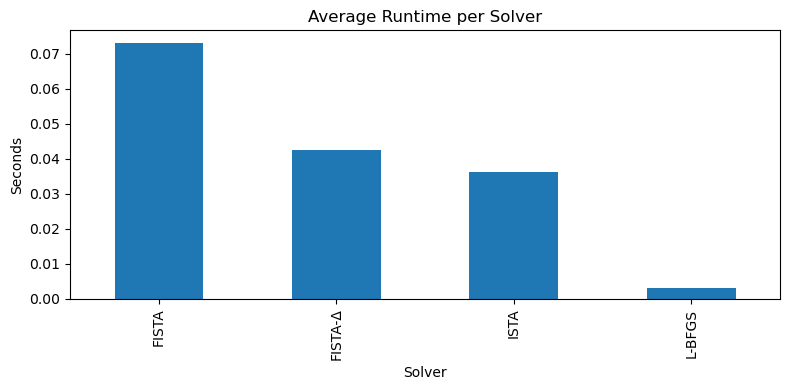

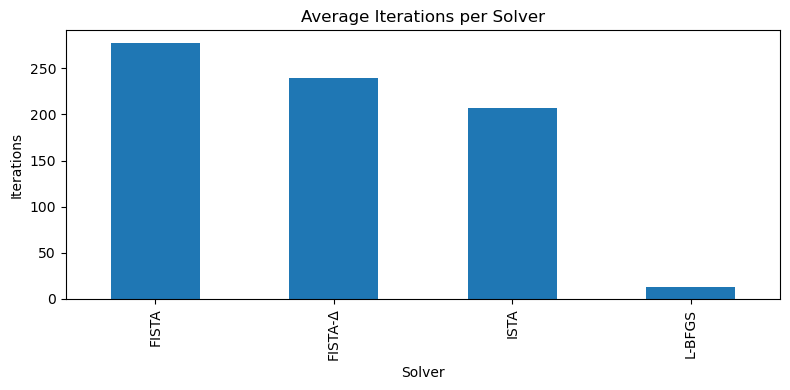

In [5]:
# … assume all_records is already populated …

import pandas as pd
import matplotlib.pyplot as plt

# 1) Build the DataFrame
df_metrics = pd.DataFrame(all_records)

# 2) (Optional) If you only want one row per scenario+solver+regularizer, you can average across repeats:
# df_metrics = df_metrics.groupby(
#     ['scenario','solver','regularizer','alpha1','alpha2']
# ).mean().reset_index()

# 3) Summary statistics per solver
summary_stats = (
    df_metrics
      .groupby('solver')
      .agg({
         'runtime_s':    ['min','max','mean','std'],
         'iterations':   ['min','max','mean','std'],
         'mem_current_b':['min','max','mean','std']
      })
)
# flatten the MultiIndex
summary_stats.columns = [
    f"{metric}_{stat}"
    for metric, stat in summary_stats.columns
]
summary_stats = summary_stats.reset_index()

print("=== Summary statistics by solver ===")
print(summary_stats.to_markdown(index=False))

# 4) A smaller “detailed” table showing mean + std of runtime and iterations for each (solver, regularizer)
detail = (
    df_metrics
      .groupby(['solver','regularizer'])
      .agg({
         'runtime_s':  ['mean','std'],
         'iterations': ['mean','std']
      })
)
detail.columns = [f"{metric}_{stat}" for metric,stat in detail.columns]
detail = detail.reset_index()

print("\n=== Mean ± SD by solver and regularizer ===")
print(detail.to_markdown(index=False))

# 5) Bar‐plot of average runtime and iterations per solver
avg = df_metrics.groupby('solver')[['runtime_s','iterations']].mean()

plt.figure(figsize=(8,4))
avg['runtime_s'].plot.bar()
plt.title('Average Runtime per Solver')
plt.ylabel('Seconds')
plt.xlabel('Solver')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
avg['iterations'].plot.bar()
plt.title('Average Iterations per Solver')
plt.ylabel('Iterations')
plt.xlabel('Solver')
plt.tight_layout()
plt.show()


In [6]:
# === COMPLETE SUBROUTINE METRICS SUMMARY ===
import pandas as pd

# list *all* the sub‐routine columns you’ve been collecting
cols = [
    'grad_num_calls', 'grad_time_total', 'grad_time_mean',
    'ls_num_calls',   'ls_time_total',   'ls_time_mean', 'ls_iters_total'
]

# aggregate mean & std by solver
sub_summary = (
    df_metrics
      .groupby('solver')[cols]
      .agg(['mean','std'])
)

# flatten the MultiIndex
sub_summary.columns = [
    f"{metric}_{stat}"
    for metric, stat in sub_summary.columns
]
sub_summary = sub_summary.reset_index()

# display
print(sub_summary.to_markdown(index=False))


| solver   |   grad_num_calls_mean |   grad_num_calls_std |   grad_time_total_mean |   grad_time_total_std |   grad_time_mean_mean |   grad_time_mean_std |   ls_num_calls_mean |   ls_num_calls_std |   ls_time_total_mean |   ls_time_total_std |   ls_time_mean_mean |   ls_time_mean_std |   ls_iters_total_mean |   ls_iters_total_std |
|:---------|----------------------:|---------------------:|-----------------------:|----------------------:|----------------------:|---------------------:|--------------------:|-------------------:|---------------------:|--------------------:|--------------------:|-------------------:|----------------------:|---------------------:|
| FISTA    |              277.375  |            108.736   |            0.00922094  |            0.00495141 |           3.2857e-05  |          9.95342e-06 |               0     |             0      |            0         |           0         |         0           |        0           |                0      |              0       